## FHE enhanced Federated Learning for logistic regression

This notebook provides an example of using FHE enhanced Federated learning for training a logistic regression model on tabular data. Note that it is a stand-alone example used to illustrate the concepts by simulation on a single server and that it does not distribute data over multiple nodes. It also presents some simple numerical investigations and benchmarking of operations in TenSEAL CKKS library.


In [1]:
import torch
import tenseal as ts
import pandas as pd
import random
from time import time

# those are optional and are not necessary for training
import numpy as np
import matplotlib.pyplot as plt

from torchmetrics.classification import BinaryAccuracy
accuracy = BinaryAccuracy()


### Crytographic parameters

In [2]:
# parameters
param = [4096,8192][1]

if param==4096:
    poly_mod_degree = 4096
    coeff_mod_bit_sizes = [40, 20, 40]
    context = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
    context.global_scale = 2 ** 20
else:
    poly_mod_degree = 8192
    #coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
    coeff_mod_bit_sizes = [60,40,40,60]
    context = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
    #context.global_scale = 2 ** 21
    context.global_scale = 2 ** 40
    
# this key is needed for doing dot-product operations
context.generate_galois_keys()


### Load data and preprocess

First load data from the Framingham dataset

- https://biolincc.nhlbi.nih.gov/studies/framcohort/


In [3]:
# load dataset and drop nans

df_raw = pd.read_csv("./data/framingham.csv")
print(df_raw.shape)
df_raw = df_raw.dropna()
print(df_raw.shape)
df_raw = df_raw.drop(columns=["education", "currentSmoker", "BPMeds", "diabetes", "diaBP", "BMI"])#.dropna()
print(df_raw.shape)
df_raw = df_raw.dropna()
print(df_raw.shape)

df_raw.head()


(4238, 16)
(3656, 16)
(3656, 10)
(3656, 10)


,male,age,cigsPerDay,prevalentStroke,prevalentHyp,totChol,sysBP,heartRate,glucose,TenYearCHD
0,1,39,0.0,0,0,195.0,106.0,80.0,77.0,0
1,0,46,0.0,0,0,250.0,121.0,95.0,76.0,0
2,1,48,20.0,0,0,245.0,127.5,75.0,70.0,0
3,0,61,30.0,0,1,225.0,150.0,65.0,103.0,1
4,0,46,23.0,0,0,285.0,130.0,85.0,85.0,0


In [4]:
# quick check of class imbalance

df_grouped = df_raw.groupby('TenYearCHD')
df_grouped.count()


,male,age,cigsPerDay,prevalentStroke,prevalentHyp,totChol,sysBP,heartRate,glucose
TenYearCHD,,,,,,,,,
0,3099,3099,3099,3099,3099,3099,3099,3099,3099
1,557,557,557,557,557,557,557,557,557


In [5]:
# balance by resampling both groups

df_balanced = df_grouped.apply(lambda x: x.sample(500, random_state=73).reset_index(drop=True))
df_balanced.describe()


,male,age,cigsPerDay,prevalentStroke,prevalentHyp,totChol,sysBP,heartRate,glucose,TenYearCHD
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,0.472000,51.656000,9.169000,0.007000,0.386000,238.652000,136.686500,75.553000,84.044000,0.50000
std,0.499465,8.649073,12.115082,0.083414,0.487074,43.659398,24.622789,12.138803,32.487991,0.50025
min,0.000000,34.000000,0.000000,0.000000,0.000000,124.000000,83.500000,48.000000,40.000000,0.00000
25%,0.000000,45.000000,0.000000,0.000000,0.000000,209.000000,119.000000,67.000000,71.000000,0.00000
50%,0.000000,52.000000,0.000000,0.000000,0.000000,238.000000,132.000000,75.000000,78.000000,0.50000
75%,1.000000,59.000000,20.000000,0.000000,1.000000,266.000000,149.000000,82.000000,87.000000,1.00000
max,1.000000,69.000000,60.000000,1.000000,1.000000,464.000000,295.000000,143.000000,394.000000,1.00000


In [6]:
# normalize all feature columns

df = df_balanced.reset_index(drop=True).drop(columns="TenYearCHD").apply(lambda x: (x-x.mean())/ x.std(), axis=0)
df["TenYearCHD"] = df_balanced["TenYearCHD"].reset_index(drop=True)
df = df.sample(len(df), random_state=42) # why do we do this?
df.describe()


,male,age,cigsPerDay,prevalentStroke,prevalentHyp,totChol,sysBP,heartRate,glucose,TenYearCHD
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1000.00000
mean,5.684342e-17,1.483258e-16,-1.865175e-17,1.065814e-17,8.881784e-19,3.073097e-16,1.803002e-16,2.380318e-16,1.065814e-16,0.50000
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.50025
min,-9.450108e-01,-2.041375e+00,-7.568252e-01,-8.391839e-02,-7.924871e-01,-2.626055e+00,-2.160052e+00,-2.269828e+00,-1.355701e+00,0.00000
25%,-9.450108e-01,-7.695622e-01,-7.568252e-01,-8.391839e-02,-7.924871e-01,-6.791665e-01,-7.182980e-01,-7.045999e-01,-4.015022e-01,0.00000
50%,-9.450108e-01,3.977305e-02,-7.568252e-01,-8.391839e-02,-7.924871e-01,-1.493378e-02,-1.903318e-01,-4.555639e-02,-1.860380e-01,0.50000
75%,1.057131e+00,8.491083e-01,8.940096e-01,-8.391839e-02,1.260588e+00,6.263943e-01,5.000855e-01,5.311067e-01,9.098747e-02,1.00000
max,1.057131e+00,2.005302e+00,4.195679e+00,1.190442e+01,1.260588e+00,5.161500e+00,6.429552e+00,5.556314e+00,9.540633e+00,1.00000


In [7]:
# split into test data and training data
# and partition it over the federation

train_len = 800
n_parts = 16

part_len = train_len//n_parts

X_trn = torch.tensor(df.iloc[:train_len,:-1].values).float().split(part_len)
Y_trn = torch.tensor(df.iloc[:train_len,-1:].values).float().split(part_len)
X_tst = torch.tensor(df.iloc[train_len:,:-1].values).float()
Y_tst = torch.tensor(df.iloc[train_len:,-1:].values).float()

print(f"X_trn has size: {X_trn[0].shape}")
print(f"Y_trn has size: {Y_trn[0].shape}")
print(f"X_tst has size: {X_tst.shape}")
print(f"Y_tst has size: {Y_tst.shape}")


X_trn has size: torch.Size([50, 9])
Y_trn has size: torch.Size([50, 1])
X_tst has size: torch.Size([200, 9])
Y_tst has size: torch.Size([200, 1])


### Define model and the training procedure

In [8]:
class LR(torch.nn.Module):

    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)
        
    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out


In [9]:
def addition_tree(parts):
    n = len(parts)
    if n==1:
        return parts[0]
    elif n%2==0:
        return addition_tree(parts[:n//2]) + addition_tree(parts[n//2:]) 
    else:
        print("Error: length must power of 2")
        return None
    
addition_tree([1,2,3,4]), addition_tree(Y_trn).shape  
#addition_tree([model.weight() for model in models])   
#addition_tree([model.bias() for model in models])   


(10, torch.Size([50, 1]))

In [10]:
n_features = X_trn[0].shape[1]
n_epochs = 5

# use Binary Cross Entropy Loss
criterion = torch.nn.BCELoss()

def train_distr(context = None, verbose = True):
    models = [LR(n_features) for i in range(n_parts)]
    optims = [torch.optim.SGD(model.parameters(), lr=1) for model in models]
    for i in range(n_epochs):
        # Each part takes a gradient step to modify params based on their data
        for j in range(n_parts):
            optims[j].zero_grad()
            out = models[j](X_trn[j])
            loss = criterion(out, Y_trn[j])
            if verbose:
                print(f"Epoch {i} loss for part {j}: {loss.data}")
            loss.backward()
            optims[j].step()
        weights = [model.state_dict()["lr.weight"]/n_parts for model in models]
        biases = [model.state_dict()["lr.bias"]/n_parts for model in models]
        if context is not None:
            # Each partys new params are encrypted before sharing
            weights = [ts.ckks_vector(context, w.tolist()[0]) for w in weights]
            biases = [ts.ckks_vector(context, b.tolist()) for b in biases]
        # Aggregate (encrypted) params accross federation 
        aggr_weight = addition_tree(weights)
        aggr_bias = addition_tree(biases)
        if context is not None:
            # Coordinating party receives aggregates and decrypts
            aggr_weight = torch.tensor(aggr_weight.decrypt())[None,:]
            aggr_bias = torch.tensor(aggr_bias.decrypt())
        state_dict = models[0].state_dict().copy()
        state_dict["lr.weight"] = aggr_weight
        state_dict["lr.bias"] = aggr_bias        
        # Aggregate params are shared with all parts who update their model
        for model in models:
            model.load_state_dict(state_dict.copy())
    return models


## Distributed training with plain text aggregation

In [11]:
plain_models = train_distr()
#models = train_distr(context)

for j, model in enumerate(plain_models):
    out = model(X_trn[j])
    loss = criterion(out, Y_trn[j])
    print(f"Epoch {n_epochs} loss for part {j}: {loss.data}")

plain_prediction = plain_models[0](X_tst)
plain_accuracy = accuracy(plain_prediction,Y_tst)
print(f"Plain model accuracy on test set: {plain_accuracy}")
    

Epoch 0 loss for part 0: 0.8149416446685791
Epoch 0 loss for part 1: 0.6511636972427368
Epoch 0 loss for part 2: 0.7455995678901672
Epoch 0 loss for part 3: 0.7385343909263611
Epoch 0 loss for part 4: 0.7250063419342041
Epoch 0 loss for part 5: 0.7649796009063721
Epoch 0 loss for part 6: 0.8047153353691101
Epoch 0 loss for part 7: 0.7104365825653076
Epoch 0 loss for part 8: 0.7022174000740051
Epoch 0 loss for part 9: 0.725104808807373
Epoch 0 loss for part 10: 0.7941414713859558
Epoch 0 loss for part 11: 0.6610744595527649
Epoch 0 loss for part 12: 0.7533765435218811
Epoch 0 loss for part 13: 0.6060540080070496
Epoch 0 loss for part 14: 0.7035385370254517
Epoch 0 loss for part 15: 0.7997987866401672
Epoch 1 loss for part 0: 0.6126331090927124
Epoch 1 loss for part 1: 0.6306044459342957
Epoch 1 loss for part 2: 0.6045825481414795
Epoch 1 loss for part 3: 0.6438902020454407
Epoch 1 loss for part 4: 0.6421604156494141
Epoch 1 loss for part 5: 0.6016902327537537
Epoch 1 loss for part 6: 0.

## Distributed training with encypted aggregation

In [12]:
crypt_models = train_distr(context)

for j, model in enumerate(crypt_models):
    out = model(X_trn[j])
    loss = criterion(out, Y_trn[j])
    print(f"Epoch {n_epochs} loss for part {j}: {loss.data}")

crypt_prediction = crypt_models[0](X_tst)
crypt_accuracy = accuracy(crypt_prediction,Y_tst)
print(f"Plain model accuracy on test set: {crypt_accuracy}")


Epoch 0 loss for part 0: 0.7411450147628784
Epoch 0 loss for part 1: 0.7024632096290588
Epoch 0 loss for part 2: 0.7412488460540771
Epoch 0 loss for part 3: 0.7115241885185242
Epoch 0 loss for part 4: 0.6948277354240417
Epoch 0 loss for part 5: 0.7146217823028564
Epoch 0 loss for part 6: 0.6938413381576538
Epoch 0 loss for part 7: 0.6975741386413574
Epoch 0 loss for part 8: 0.695701539516449
Epoch 0 loss for part 9: 0.7239783406257629
Epoch 0 loss for part 10: 0.8271534442901611
Epoch 0 loss for part 11: 0.655357301235199
Epoch 0 loss for part 12: 0.676021933555603
Epoch 0 loss for part 13: 0.704988956451416
Epoch 0 loss for part 14: 0.7365888953208923
Epoch 0 loss for part 15: 0.8063575625419617
Epoch 1 loss for part 0: 0.6071261763572693
Epoch 1 loss for part 1: 0.6345487833023071
Epoch 1 loss for part 2: 0.6068189144134521
Epoch 1 loss for part 3: 0.6544774770736694
Epoch 1 loss for part 4: 0.639777660369873
Epoch 1 loss for part 5: 0.6126546263694763
Epoch 1 loss for part 6: 0.6215

## Collect stats for training and evaluate performance

In [13]:
no_trials = 5 # 100
verbose = False

tst = []


for i in range(no_trials):
    row = []
    
    t0 = time()
    plain_models = train_distr(verbose=False)
    row.append(time()-t0)
    
    plain_prediction = plain_models[0](X_tst)
    plain_accuracy = accuracy(plain_prediction,Y_tst).tolist()
    row.append(plain_accuracy)
    
    t1 = time()
    crypt_models = train_distr(context,verbose=False)
    row.append(time()-t1)

    crypt_prediction = crypt_models[0](X_tst)
    crypt_accuracy = accuracy(crypt_prediction,Y_tst).tolist()
    row.append(crypt_accuracy)
    
    weight = plain_models[0].state_dict()["lr.weight"]
    bias = plain_models[0].state_dict()["lr.bias"]
    t1 = time()
    weight = ts.ckks_vector(context, weight.tolist()[0])
    bias = ts.ckks_vector(context, bias.tolist())
    row.append(time()-t1)

    t1 = time()
    weight = addition_tree([weight, weight])
    bias = addition_tree([bias, bias])
    row.append(time()-t1)

    t1 = time()
    weight.decrypt()
    bias.decrypt()
    row.append(time()-t1)
    
    tst.append(row)
    print(f"Round {i+1} completed in {time()-t0}")

res = pd.DataFrame(tst, columns=["plain_time","plain_acc","crypt_time","crypt_acc",
                                                    "enc_time","add_time","dec_time"])
res

Round 1 completed in 0.960601806640625
Round 2 completed in 0.9813790321350098
Round 3 completed in 0.9766154289245605
Round 4 completed in 0.9722967147827148
Round 5 completed in 0.9742403030395508


,plain_time,plain_acc,crypt_time,crypt_acc,enc_time,add_time,dec_time
0,0.034602,0.685,0.910826,0.695,0.010585,0.000160,0.002966
1,0.032610,0.690,0.933302,0.710,0.010718,0.000157,0.003047
2,0.029844,0.695,0.931195,0.685,0.010757,0.000158,0.002987
3,0.032437,0.685,0.924915,0.685,0.010352,0.000153,0.002884
4,0.030136,0.705,0.929010,0.690,0.010466,0.000154,0.002888


In [14]:
!mkdir -p figs

tmp = res.describe()
tmp.to_csv(f"figs/stats_distr_{param}_{n_parts}.csv")
tmp


,plain_time,plain_acc,crypt_time,crypt_acc,enc_time,add_time,dec_time
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.031926,0.692000,0.925850,0.693000,0.010576,0.000156,0.002954
std,0.001964,0.008367,0.008953,0.010368,0.000170,0.000003,0.000069
min,0.029844,0.685000,0.910826,0.685000,0.010352,0.000153,0.002884
25%,0.030136,0.685000,0.924915,0.685000,0.010466,0.000154,0.002888
50%,0.032437,0.690000,0.929010,0.690000,0.010585,0.000157,0.002966
75%,0.032610,0.695000,0.931195,0.695000,0.010718,0.000158,0.002987
max,0.034602,0.705000,0.933302,0.710000,0.010757,0.000160,0.003047


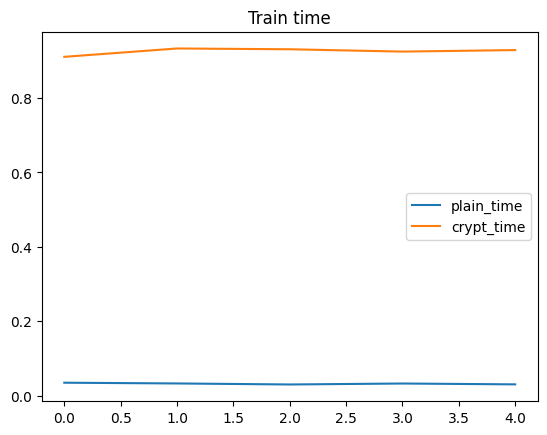

In [15]:
res.iloc[:,[0,2]].plot()
plt.legend()
plt.title("Train time")
plt.savefig(f"figs/traintime_distr_{param}_{n_parts}.png")
plt.show()


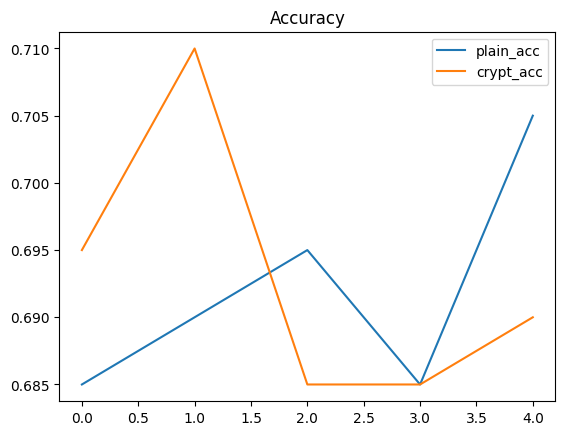

In [16]:
res.iloc[:,[1,3]].plot()
plt.legend()
plt.title("Accuracy")
plt.savefig(f"figs/accuracy_distr_{param}_{n_parts}.png")
plt.show()


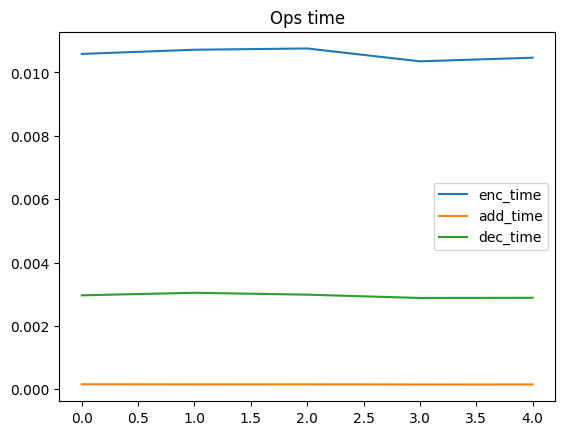

In [17]:
res.iloc[:,4:].plot()
plt.legend()
plt.title("Ops time")
plt.savefig(f"figs/ops_time_distr_{param}_{n_parts}.png")
plt.show()


In [18]:
res.to_csv(f"figs/results_distr_{param}_{n_parts}.csv")
